## 0. Introduction

In this notebook we're going to build and train a deep learning model "from scratch" -- by which I mean that we're not going to use any pre-built architecture, or optimizers, or data loading frameworks, etc.

We'll be using Kaggle's Titanic competition in this notebook, because it's very small and simple, but also has displays many of the tricky real-life issues that we need to handle in most practical projects. (Note, however, that this competition is a small "learner" competition on Kaggle, so don't expect to actually see much benefits from using a neural net just yet; that will come once we try our some real competitions!)

In [3]:
from pathlib import Path

path_data = Path('data')
path_comp = Path('titanic')
path = path_data / path_comp

if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path_comp))
    zipfile.ZipFile(f"{path_comp}.zip").extractall(path)

In [4]:
import torch, numpy as np, pandas as pd
np.printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## 1. Cleaning the data

This is a tabular data competition -- the data is in the form of a table. It's provided as a Comma Separated Values (CSV) file. We can open it using the pandas library, which will create a DataFrame.

In [5]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


As we learned in the How does a neural net really work notebook, we going to want to multiply each column by some coefficients. But we can see in the Cabin column that there are NaN values, which is how Pandas refers to missing values. We can't multiply something by a missing value!

Let's check which columns contain NaN values. Pandas' isna() function returns True (which is treated as 1 when used as a number) for NaN values, so we can just add them up for each column:

In [8]:
df.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Notice that by default Pandas sums over columns.

We'll need to replace the missing values with something. It doesn't generally matter too much what we choose. We'll use the most common value (the "mode"). We can use the mode function for that. One wrinkle is that it returns more than one row in the case of ties, so we just grab the first row with iloc[0]:

In [413]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [414]:
df.fillna(modes, inplace=True)

Here's how we get a quick summary of all the numeric columns in the dataset:

In [415]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that Fare contains mainly values of around 0 to 30, but there's a few really big ones. This is very common with fields contain monetary values, and it can cause problems for our model, because once that column is multiplied by a coefficient later, the few rows with really big values will dominate the result.

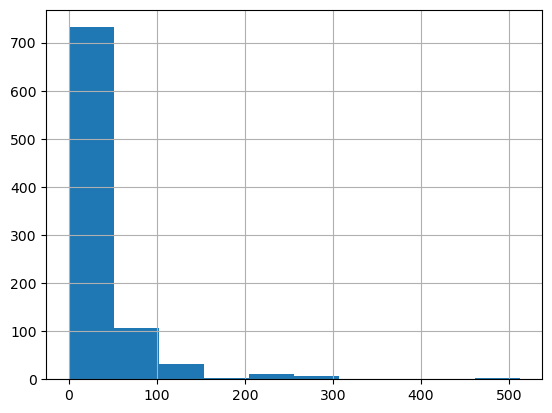

In [416]:
df['Fare'].hist();

To fix this, the most common approach is to take the logarithm, which squishes the big numbers and makes the distribution more reasonable. Note, however, that there are zeros in the Fare column, and log(0) is infinite -- to fix this, we'll simply add 1 to all values first:

In [417]:
df['LogFare'] = np.log(df['Fare'] + 1)

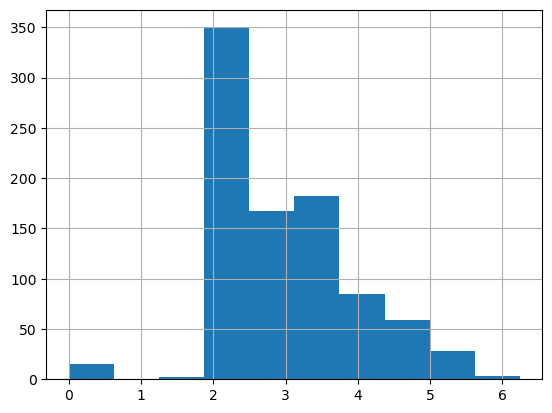

In [418]:
df['LogFare'].hist();

It looks from the describe() output like Pclass contains just 3 values, which we can confirm by looking at the Data Dictionary (which you should always study carefully for any project!) --

In [419]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Here's how we get a quick summary of all the non-numeric columns in the dataset:

In [420]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Clearly we can't multiply strings like male or S by coefficients, so we need to replace those with numbers.

We do that by creating new columns containing dummy variables. A dummy variable is a column that contains a 1 where a particular column contains a particular value, or a 0 otherwise. For instance, we could create a dummy variable for Sex='male', which would be a new column containing 1 for rows where Sex is 'male', and 0 for rows where it isn't.

Pandas can create these automatically using get_dummies, which also remove the original columns. We'll create dummy variables for Pclass, even although it's numeric, since the numbers 1, 2, and 3 correspond to first, second, and third class cabins - not to counts or measures that make sense to multiply by. We'll also create dummies for Sex and Embarked since we'll want to use those as predictors in our model. On the other hand, Cabin, Name, and Ticket have too many unique values for it to make sense creating dummy variables for them.

In [421]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

We can see that 5 columns have been added to the end -- one for each of the possible values of each of the three columns we requested, and that those three requested columns have been removed.

Here's what the first few rows of those newly added columns look like:

In [422]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


Now we can create our independent (predictors) and dependent (target) variables. They both need to be PyTorch tensors. Our dependent variable is Survived:

In [423]:
from torch import tensor

t_dep = tensor(df.Survived)

Our independent variables are all the continuous variables of interest plus all the dummy variables we just created:

In [424]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].astype(np.float32).values)
t_indep.dtype

torch.float32

In [425]:
t_indep.shape

torch.Size([891, 12])

## 2. Setting up a linear model

Now that we've got a matrix of independent variables and a dependent variable vector, we can work on calculating our predictions and our loss. In this section, we're going to manually do a single step of calculating predictions and loss for every row of our data.

Our first model will be a simple linear model. We'll need a coefficient for each column in t_indep. We'll pick random numbers in the range (-0.5,0.5), and set our manual seed so that my explanations in the prose in this notebook will be consistent with what you see when you run it.

In [426]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5
coeffs

tensor([     0.2124,     -0.3234,     -0.1986,      0.1020,     -0.0053,     -0.3298,     -0.4567,      0.2992,     -0.0002,      0.0430,
             0.4079,      0.2971])

Our predictions will be calculated by multiplying each row by the coefficients, and adding them up. One interesting point here is that we don't need a separate constant term (also known as a "bias" or "intercept" term), or a column of all 1s to give the same effect has having a constant term. That's because our dummy variables already cover the entire dataset -- e.g. there's a column for "male" and a column for "female", and everyone in the dataset is in exactly one of these; therefore, we don't need a separate intercept term to cover rows that aren't otherwise part of a column.

Here's what the multiplication looks like:

In [427]:
t_indep*coeffs

tensor([[     4.6719,     -0.3234,     -0.0000,      0.2152,     -0.0053,     -0.0000,     -0.0000,      0.0000,     -0.0002,      0.0000,
              0.0000,      0.2971],
        [     8.0696,     -0.3234,     -0.0000,      0.4366,     -0.0000,     -0.3298,     -0.4567,      0.0000,     -0.0000,      0.0430,
              0.0000,      0.0000],
        [     5.5213,     -0.0000,     -0.0000,      0.2232,     -0.0000,     -0.3298,     -0.0000,      0.0000,     -0.0002,      0.0000,
              0.0000,      0.2971],
        [     7.4326,     -0.3234,     -0.0000,      0.4070,     -0.0000,     -0.3298,     -0.4567,      0.0000,     -0.0000,      0.0000,
              0.0000,      0.2971],
        [     7.4326,     -0.0000,     -0.0000,      0.2247,     -0.0053,     -0.0000,     -0.0000,      0.0000,     -0.0002,      0.0000,
              0.0000,      0.2971],
        [     5.0966,     -0.0000,     -0.0000,      0.2292,     -0.0053,     -0.0000,     -0.0000,      0.0000,     -0.0002,

We can see we've got a problem here. The sums of each row will be dominated by the first column, which is Age, since that's bigger on average than all the others.

Let's make all the columns contain numbers from 0 to 1, by dividing each column by its max():

In [428]:
vals, indices = t_indep.max(dim=0)
t_indep /= vals

In [429]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([ 0.3440, -0.6131,  0.0719, -0.3717,  0.4204,  0.5028,  0.0433,  0.1930,  0.0133,  0.0652])

Of course, these predictions aren't going to be any use, since our coefficients are random -- they're just a starting point for our gradient descent process.

To do gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [430]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5974)

In [431]:
def calc_preds(coeffs, indeps): return (indeps * coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

## 3. Doing a gradient descent step

In this section, we're going to do a single "epoch" of gradient descent manually. The only thing we're going to automate is calculating gradients, because let's face it that's pretty tedious and entirely pointless to do by hand! To get PyTorch to calculate gradients, we'll need to call requires_grad_() on our coeffs (if you're not sure why, review the previous notebook, How does a neural net really work?, before continuing):

In [432]:
coeffs.requires_grad_()

tensor([     0.2124,     -0.3234,     -0.1986,      0.1020,     -0.0053,     -0.3298,     -0.4567,      0.2992,     -0.0002,      0.0430,
             0.4079,      0.2971], requires_grad=True)

Now when we calculate our loss, PyTorch will keep track of all the steps, so we'll be able to get the gradients afterwards:

In [433]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5974, grad_fn=<MeanBackward0>)

In [434]:
loss.backward()

In [435]:
coeffs.grad

tensor([ 0.0141, -0.0081, -0.0277, -0.0611,  0.2750, -0.2536, -0.1975,  0.0112,  0.2076, -0.0965,  0.0191,  0.0988])

Note that each time we call backward, the gradients are actually added to whatever is in the .grad attribute. Let's try running the above steps again:

In [436]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 0.0282, -0.0163, -0.0554, -0.1221,  0.5499, -0.5073, -0.3951,  0.0224,  0.4153, -0.1930,  0.0382,  0.1975])

As you see, our .grad values are have doubled. That's because it added the gradients a second time. For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.

We can now do one gradient descent step, and check that our loss decreases:

In [437]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.inference_mode():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5261)


## 4. Training the linear model

Before we begin training our model, we'll need to ensure that we hold out a validation set for calculating our metrics (for details on this, see "Getting started with NLP for absolute beginners".

There's lots of different ways we can do this. In the next notebook we'll be comparing our approach here to what the fastai library does, so we'll want to ensure we split the data in the same way. So let's use RandomSplitter to get indices that will split our data into training and validation sets:

In [438]:
from fastai.data.transforms import RandomSplitter
trn_split, val_split = RandomSplitter()(df)

Now we can apply those indices to our independent and dependent variables:

In [439]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_dep), len(val_dep)

(713, 178)

We'll create functions for the three things we did manually above: updating coeffs, doing one full gradient descent step, and initilising coeffs to random numbers:

In [440]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [441]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.inference_mode(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [442]:
def init_coeffs():
    return (torch.rand(n_coeff) - 0.5).requires_grad_()

We can now use these functions to train our model:

In [443]:
def train_model(epochs = 30, lr = 0.01):
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr)
    return coeffs

In [444]:
coeffs = train_model(18, lr=0.2)

1.124; 0.757; 0.502; 0.460; 0.422; 0.405; 0.391; 0.385; 0.361; 0.362; 0.344; 0.339; 0.328; 0.318; 0.311; 0.300; 0.296; 0.290; 

In [445]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.1450),
 'SibSp': tensor(0.0206),
 'Parch': tensor(-0.2640),
 'LogFare': tensor(0.4684),
 'Sex_male': tensor(-0.3077),
 'Sex_female': tensor(0.3551),
 'Pclass_1': tensor(0.3010),
 'Pclass_2': tensor(0.3271),
 'Pclass_3': tensor(0.0922),
 'Embarked_C': tensor(0.0873),
 'Embarked_Q': tensor(-0.0145),
 'Embarked_S': tensor(-0.0171)}

## 5. Measuring accuracy

The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by accuracy -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions:

In [446]:
preds = calc_preds(coeffs, val_indep)

We'll assume that any passenger with a score of over 0.5 is predicted to survive. So that means we're correct for each row where preds>0.5 is the same as the dependent variable:

In [447]:
results = val_dep.bool() == (preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True])

Let's see what our average accuracy is:

In [448]:
results.float().mean()

tensor(0.8258)

That's not a bad start at all! We'll create a function so we can calcuate the accuracy easy for other models we train:

In [449]:
def acc(coeffs): return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()
acc(coeffs)

tensor(0.8258)

## 6. Using sigmoid

Looking at our predictions, there's one obvious problem -- some of our predictions of the probability of survival are >1, and some are <0:

In [450]:
preds[28:100]

tensor([ 0.3087,  0.3643, -0.1216,  0.5531, -0.0135, -0.1811,  0.2665,  0.5710, -0.1470, -0.1030, -0.1261,  0.1237,  0.9886,  1.0191,
        -0.1084,  1.0599, -0.1086,  0.5963, -0.1263,  0.4931, -0.1093, -0.1068, -0.1043,  0.2876,  0.7828, -0.0970, -0.0411, -0.1123,
         0.7980,  0.5455, -0.0604,  0.8483,  0.0208,  0.5144, -0.0893,  0.6096,  0.8391, -0.1139,  0.5519, -0.1201,  0.4806, -0.1406,
         0.1128,  0.6991,  0.1222,  0.2303, -0.0386,  0.1128,  0.1580,  0.9073,  0.5987, -0.1155,  0.1331,  0.7943, -0.0063, -0.0899,
         0.6024,  0.0101, -0.0077,  0.1204, -0.0986,  0.5487,  0.5707, -0.1126,  0.2913, -0.1480, -0.1152,  0.5533, -0.1193,  0.9629,
         0.7974, -0.1109])

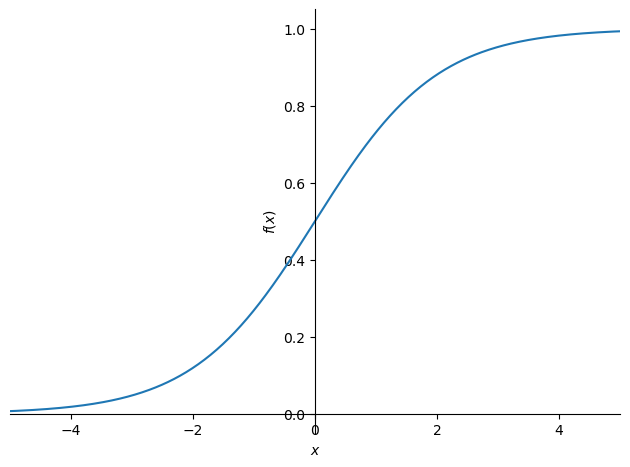

In [451]:
import sympy as sp
x = sp.Symbol('x')
sp.plot(1/(1+sp.exp(-x)), xlim=(-5,5));

PyTorch already defines that function for us, so we can modify calc_preds to use it:

In [452]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [453]:
coeffs = train_model(lr = 100)

0.522; 0.310; 0.214; 0.201; 0.194; 0.192; 0.190; 0.189; 0.189; 0.188; 0.188; 0.188; 0.187; 0.187; 0.187; 0.187; 0.187; 0.187; 0.187; 0.187; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 

In [454]:
acc(coeffs)

tensor(0.7921)

In [455]:
show_coeffs()

{'Age': tensor(-1.1242),
 'SibSp': tensor(-0.7366),
 'Parch': tensor(-0.4432),
 'LogFare': tensor(0.7788),
 'Sex_male': tensor(-9.2367),
 'Sex_female': tensor(7.9226),
 'Pclass_1': tensor(2.8376),
 'Pclass_2': tensor(2.5314),
 'Pclass_3': tensor(-6.5389),
 'Embarked_C': tensor(2.2859),
 'Embarked_Q': tensor(2.6483),
 'Embarked_S': tensor(-5.0586)}

## 7. Submitting to Kaggle

Now that we've got a trained model, we can prepare a submission to Kaggle. To do that, first we need to read the test set:

In [456]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [457]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df.Fare + 1)
tst_df = pd.get_dummies(tst_df, columns=['Sex', 'Pclass', 'Embarked'])

tst_indep = tensor(tst_df[indep_cols].astype(np.float32).values)
tst_indep /= vals

In [458]:
tst_df['Survived'] = (calc_preds(coeffs, tst_indep)>0.5).int()

In [459]:
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('outputs/05_titanic.csv', index=False)

## 8. Using matrix product

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [460]:
(val_indep*coeffs).sum(axis=1)

tensor([-13.1148, -20.8264,   5.7959, -21.1080, -13.6055,  -3.7303,   5.4983, -11.4788,   5.3774, -21.2314, -11.9088, -11.9530,   3.9654,
        -11.3679, -12.0784,   3.9654,   3.3051, -11.8561, -11.7261,   5.3725,   3.5953, -20.9989, -20.8967,  -4.2125,  -3.7500, -20.8988,
          5.5354,  12.6592,  -4.5000,  -4.0471, -21.0125,  -3.7134, -13.5640, -21.4000, -11.0832,  -3.7719, -21.1777, -20.8285, -21.0737,
        -11.8309,   5.9627,  13.2396, -20.8707,  13.2222, -20.9484,  -3.9535, -21.0108,  -4.2657, -20.8721, -20.9343, -21.1007, -11.7474,
          5.3004, -20.8518, -12.1011, -21.0066,   5.2404,  -3.7812, -20.9093,   5.5543, -20.7222,  -3.8013, -20.7049,  -3.7855,   5.3448,
        -21.1388,   3.9651, -20.9564,  -3.8906, -13.4258, -11.9152,   3.5820, -11.9510, -11.6286, -13.6035, -11.9152, -11.6745,  12.7668,
         -3.7781, -20.9045, -11.8666,   5.1908, -13.5078, -20.8179,  -3.8417, -20.8281, -13.5543, -11.9650, -20.8323,  -3.7207,   4.0958,
        -13.2082,  -4.0501, -21.17

Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the @ operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so:

In [461]:
val_indep@coeffs

tensor([-13.1148, -20.8264,   5.7959, -21.1080, -13.6055,  -3.7303,   5.4983, -11.4788,   5.3774, -21.2314, -11.9088, -11.9530,   3.9654,
        -11.3679, -12.0784,   3.9654,   3.3051, -11.8561, -11.7261,   5.3725,   3.5953, -20.9989, -20.8967,  -4.2125,  -3.7500, -20.8988,
          5.5354,  12.6592,  -4.5000,  -4.0471, -21.0125,  -3.7134, -13.5640, -21.4000, -11.0832,  -3.7719, -21.1777, -20.8285, -21.0737,
        -11.8309,   5.9627,  13.2396, -20.8707,  13.2222, -20.9484,  -3.9535, -21.0108,  -4.2657, -20.8721, -20.9343, -21.1007, -11.7474,
          5.3004, -20.8518, -12.1011, -21.0066,   5.2404,  -3.7812, -20.9093,   5.5543, -20.7222,  -3.8013, -20.7049,  -3.7855,   5.3448,
        -21.1388,   3.9651, -20.9564,  -3.8906, -13.4258, -11.9152,   3.5820, -11.9510, -11.6286, -13.6035, -11.9152, -11.6745,  12.7668,
         -3.7781, -20.9045, -11.8666,   5.1908, -13.5078, -20.8179,  -3.8417, -20.8281, -13.5543, -11.9650, -20.8323,  -3.7207,   4.0958,
        -13.2082,  -4.0501, -21.17

In [462]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In order to do matrix-matrix products (which we'll need in the next section), we need to turn coeffs into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument 1 to torch.rand(), indicating that we want our coefficients to have one column:

In [463]:
def init_coeffs(): return (torch.rand(n_coeff, 1) * 0.1).requires_grad_()

We'll also need to turn our dependent variable into a column vector, which we can do by indexing the column dimension with the special value None, which tells PyTorch to add a new dimension in this position:

In [464]:
trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]

We can now train our model as before and confirm we get identical outputs...:

In [465]:
coeffs = train_model(lr=100)

0.512; 0.316; 0.236; 0.199; 0.194; 0.191; 0.190; 0.189; 0.188; 0.188; 0.188; 0.187; 0.187; 0.187; 0.187; 0.187; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 0.186; 

... and identical accuracy:

In [466]:
acc(coeffs)

tensor(0.7921)

## 9. A neural network

We've now got what we need to implement our neural network.

First, we'll need to create coefficients for each of our layers. Our first set of coefficients will take our n_coeff inputs, and create n_hidden outputs. We can choose whatever n_hidden we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size n_coeff by n_hidden. We'll divide these coefficients by n_hidden so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.

Then our second layer will need to take the n_hidden inputs and create a single output, so that means we need a n_hidden by 1 matrix there. The second layer will also need a constant term added.

In [468]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5) / n_hidden
    layer2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, indeps@l1 and res@l2 (where res is the output of the first layer). The first layer output is passed to F.relu (that's our non-linearity), and the second is passed to torch.sigmoid as before.

In [467]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one:

In [469]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [474]:
coeffs = train_model(lr=20)

0.528; 0.430; 0.306; 0.249; 0.240; 0.222; 0.203; 0.217; 0.200; 0.220; 0.186; 0.186; 0.186; 0.185; 0.185; 0.185; 0.185; 0.185; 0.185; 0.185; 0.185; 0.185; 0.184; 0.184; 0.184; 0.184; 0.184; 0.184; 0.184; 0.184; 

It's looking good -- our loss is lower than before. Let's see if that translates to a better result on the validation set:

In [475]:
acc(coeffs)

tensor(0.7921)

In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

## 10. Final thoughts

The biggest differences in practical models to what we have above are:

- How initialisation and normalisation is done to ensure the model trains correctly every time
- Regularization (to avoid over-fitting)
- Modifying the neural net itself to take advantage of knowledge of the problem domain
- Doing gradient descent steps on smaller batches, rather than the whole dataset.